In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os
import contextlib

from data import load_data

In [2]:
# Train / test splitter for each item inside the meta dataset.

@contextlib.contextmanager
def temp_np_seed(seed):
    state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state)

class TrainTestSplitter(object):
    # Train / test splitter for each item inside the meta dataset.
    
    def __init__(self, test_frac=0.4, seed=12345):
        self.seed = seed
        self.test_frac = test_frac
        self.train_frac = 1 - test_frac
    
    def __call__(self, dataset):
        length = len(dataset)
        train_end_idx = int(np.floor(length * self.train_frac))
        indices = np.array(range(length))
        with temp_np_seed(self.seed):
            np.random.shuffle(indices)
        train_indices = indices[:train_end_idx]
        test_indices = indices[train_end_idx:]
        return np.take(dataset, train_indices), np.take(dataset, test_indices)
    
tts = TrainTestSplitter(test_frac=0.4)

In [3]:
# Meta Dataset.

class CurveTasks(torch.utils.data.Dataset):
    # Meta Dataset.
    
    def __init__(self, train_test_splitter, data_root="./data", meta_train=True):
        if meta_train:
            data_path = os.path.realpath(os.path.join(data_root, "data_curves_meta-train.npz"))
        else:
            data_path = os.path.realpath(os.path.join(data_root, "data_curves_meta-test.npz"))
        self.x, self.y = load_data(data_path)
        self.train_test_splitter = train_test_splitter
    
    def __getitem__(self, key):
        x_train, x_test = self.train_test_splitter(self.x[key])
        y_train, y_test = self.train_test_splitter(self.y[key])
        return (x_train, y_train), (x_test, y_test)
    
    def __len__(self):
        return len(self.x)

curves_meta_train = CurveTasks(train_test_splitter=tts, meta_train=True)
curves_meta_test = CurveTasks(train_test_splitter=tts, meta_train=False)

In [4]:
# Random sampler for the meta dataset.
random_sampler_curves_meta_train = torch.utils.data.RandomSampler(curves_meta_train, replacement=False)
random_sampler_curves_meta_test = torch.utils.data.RandomSampler(curves_meta_test, replacement=False)

In [5]:
# DataLoader for the meta dataset.
data_loader_curves_meta_train = torch.utils.data.DataLoader(curves_meta_train, sampler=random_sampler_curves_meta_train)
data_loader_curves_meta_test = torch.utils.data.DataLoader(curves_meta_test, sampler=random_sampler_curves_meta_test)

train length = 15
test length = 10


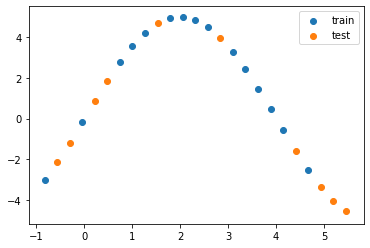

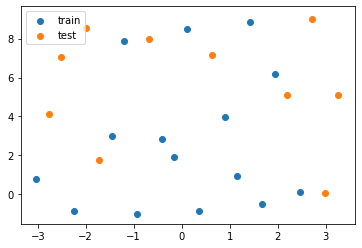

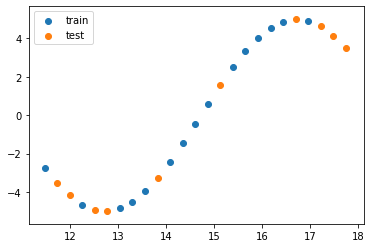

In [6]:
# Display some example meta datasets as you iterate through the DataLoader.

torch.manual_seed(42)

for idx, ((x_train, y_train), (x_test, y_test)) in enumerate(data_loader_curves_meta_train):
    if idx in (0, 4, 9):
        fig = plt.figure()
        plt.scatter(x_train.numpy(), y_train.numpy(), label="train")
        plt.scatter(x_test.numpy(), y_test.numpy(), label="test")
        plt.legend()
        if idx == 0:
            print("train length = {}".format(x_train.numpy().shape[1]))
            print("test length = {}".format(x_test.numpy().shape[1]))